# Описание проекта

Компания провела тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. Пользователи разбиты на две группы: А — контрольная, B — экспериментальная.

**Цель исследования:** оценить эффект от внедрения изменений.

**Задача:** провести оценку результатов A/B-теста.

Содержание:
1. [Загрузка и изучение данных](#1)
2. [Проверка ТЗ](#2)
3. [EDA](#3)
4. [Проверка гипотез](#4)
5. [Итоговый вывод](#5)

## Загрузка и изучение данных
<a id="1"></a>

In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')
    ab_new_users = pd.read_csv('final_ab_new_users.csv')
    ab_events = pd.read_csv('final_ab_events.csv')
    ab_participants = pd.read_csv('final_ab_participants.csv')
except:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    ab_events = pd.read_csv('/datasets/final_ab_events.csv')
    ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [3]:
# календарь маркетинговых событий
display(marketing_events.head())
print(marketing_events.info())
print(marketing_events.duplicated().sum())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
0


In [4]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
print(marketing_events['start_dt'].min())
print(marketing_events['finish_dt'].max())

2020-01-25 00:00:00
2021-01-07 00:00:00


Календарь маркетинговых событий содержит 14 событий, период с 2020-01-25 по 2021-01-07.

In [5]:
# пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
display(ab_new_users.head())
print(ab_new_users.info())
print(ab_new_users.duplicated().sum())
print(ab_new_users['user_id'].duplicated().sum())

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
0
0


In [6]:
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])
print(ab_new_users['first_date'].min())
print(ab_new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


In [7]:
ab_new_users.query('first_date > "2020-12-21"')['user_id'].nunique()

5263

Согласно ТЗ, дата остановки набора новых пользователей 2020-12-21, по факту - 2020-12-23. Исключим пользователей, зарегистрированных после 21 декабря.

In [8]:
ab_new_users_filtered = ab_new_users.query('first_date <= "2020-12-21"')

In [9]:
# действия новых пользователей
display(ab_events.head())
print(ab_events.info())
print(ab_events.duplicated().sum())
print(ab_events['user_id'].duplicated().sum())

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
0
381614


Пропуски в `details` свидетельствуют о том, что не все пользователи совершали покупки. Заменим их ну нули.

In [10]:
ab_events['details'] = ab_events['details'].fillna(0)

In [11]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])
print(ab_events['event_dt'].min())
print(ab_events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Тест завершился досрочно - 2020-12-31. Проверим на совпадение периода теста с маркетинговыми активностями.

In [12]:
start_date = ab_events['event_dt'].min()
finish_date = ab_events['event_dt'].max()
marketing_events.query('start_dt >= @start_date or finish_dt >= @start_date')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Проведение теста частично пересекается с событиями Christmas&New Year Promo и CIS New Year Gift Lottery. При этом набор новых пользователей завершен 21 декабря. События могли повлиять на активность пользователей обеих групп. Посмотрим, как менялось количество событий в течение теста.

In [13]:
# добавляем колонку с датой
ab_events['event_date'] = ab_events['event_dt'].dt.date

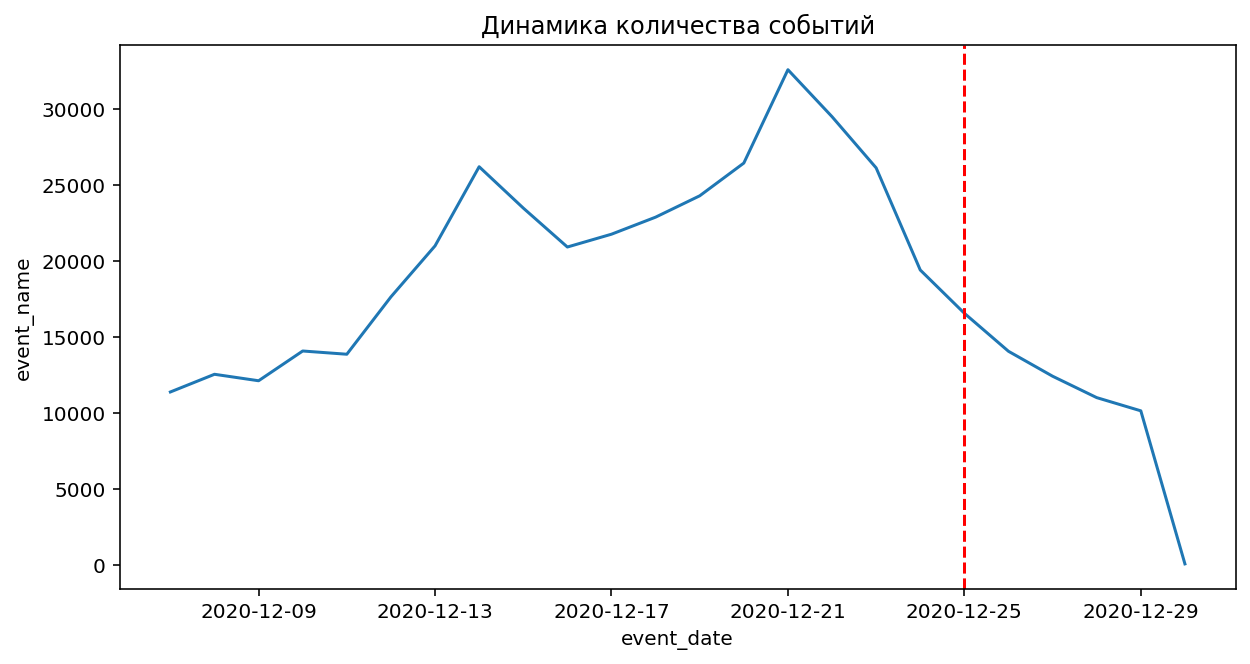

In [14]:
data_to_plot = ab_events.groupby('event_date') \
.agg({'event_name': 'count'}) \

plt.figure(figsize=(10,5))
sns.lineplot(x=data_to_plot.index, y='event_name', data=data_to_plot)
plt.axvline(dt.datetime(2020, 12, 25), color='r', ls='--')
plt.title('Динамика количества событий')
plt.show()

После 25 декабря всплеска событий не наблюдается. Напротив, активность снижалась после пика 21 декабря. Веротяно, воронка к этому времени уже сформировалась, большинство пользователей совершили запланированные действия.

In [15]:
# участники теста
display(ab_participants.head())
print(ab_participants.info())
print(ab_participants.duplicated().sum())
print(ab_participants['user_id'].duplicated().sum())

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
0
1602


In [16]:
ab_participants.value_counts('ab_test')

ab_test
interface_eu_test          11567
recommender_system_test     6701
dtype: int64

Содержатся сведения о двух А/Б тестах. Оставим пользователей, участвовавших в recommender_system_test.

In [17]:
ab_participants_filtered = ab_participants.query('ab_test == "recommender_system_test"')
ab_participants_filtered['user_id'].nunique()

6701

Пересекающихся между двумя группами пользователей нет. Проверим также на пересечение между двумя тестами.

In [18]:
cross_users = (
    ab_participants[ab_participants['ab_test'] == "recommender_system_test"]
    .merge(ab_participants[ab_participants['ab_test'] == "interface_eu_test"], 
           on='user_id', how='inner')['user_id']
    .unique()
)
len(cross_users)

1602

1602 пользователя участвовали одновременно в двух тестах. Исключим пересекающихся пользователей.

In [19]:
ab_participants_filtered = ab_participants_filtered[~ab_participants_filtered['user_id'].isin(cross_users)]
len(ab_participants_filtered)

5099

In [20]:
ab_participants_filtered.value_counts('group')

group
A    2903
B    2196
dtype: int64

Итого получили выборку из 5099 пользователей для дальнейшего анализа. Пользователи распределены неравномерно между группами.

## Проверка ТЗ
<a id="2"></a>

Объединим информацию об участниках теста, совершенных событиях и регистрациях в один датафрейм.

In [21]:
users = ab_participants_filtered \
.merge(ab_new_users_filtered, on='user_id', how='left') \
.merge(ab_events, on='user_id', how='left')
users['event_date'] = pd.to_datetime(users['event_date'])
users.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,0.00,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00,2020-12-07


**Название теста: recommender_system_test**<br>
**Ожидаемое количество участников теста: 6000**

In [22]:
users.groupby('ab_test').agg({'user_id':'nunique'})

,user_id
ab_test,
recommender_system_test,5099


Отобрано 5099 пользователей, участвующих в тесте recommender_system_test (исключены пересекающиеся между тестами пользователи). Снижение количество пользователей может повлиять на мощность теста. Оценим мощность по результатм теста.

**Группы: А — контрольная, B — новая платёжная воронка**

In [23]:
users.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,2903
B,2196


В логах есть обе группы, пересекающихся между группами пользователей нет. Сплит неравномерный (56/43), из-за чего мощность теста будет ниже, т.е. выше риск того, что изменения не будут замечены, когда она на самом деле есть.

**- дата запуска: 2020-12-07;**<br>
**- дата остановки набора новых пользователей: 2020-12-21;**<br>
**- дата остановки: 2021-01-04**<br>

In [24]:
print(users['event_date'].min()) # дата запуска
print(users['first_date'].max()) # дата остановки набора
print(users['event_date'].max()) # дата остановки теста

2020-12-07 00:00:00
2020-12-21 00:00:00
2020-12-30 00:00:00


Поскольку тест завершился раньше запланированного, не все пользователи могли "дожить" до 14 дней. Оценим лайфтаймы по каждому событию, чтобы понять, важно ли соблюдать горизонт анализа в 14 дней.

In [25]:
# добавляем столбец с лайфтаймом
users['lifetime'] = (users['event_date'] - users['first_date']).dt.days

In [26]:
def plot_lifetimes(event:str):
    '''
    Построение хитмэп по кол-ву пользователей, 
    совершивших событие event на каждый лайфтайм
    '''
    
    data = users.query('event_name == @event') \
    .pivot_table(index='first_date', columns='lifetime', values='user_id', aggfunc='nunique') \
    .fillna(0)
    
    plt.figure(figsize=(30,15))
    sns.heatmap(data, 
                annot=True, 
                fmt='g', 
                cmap='vlag', 
                yticklabels=[f'{i} дек.' for i in range(7,22)], 
                annot_kws={'size': 15})
    plt.title(f'Хитмэп по кол-ву пользователей, совершивших событие {event}')
    plt.show()

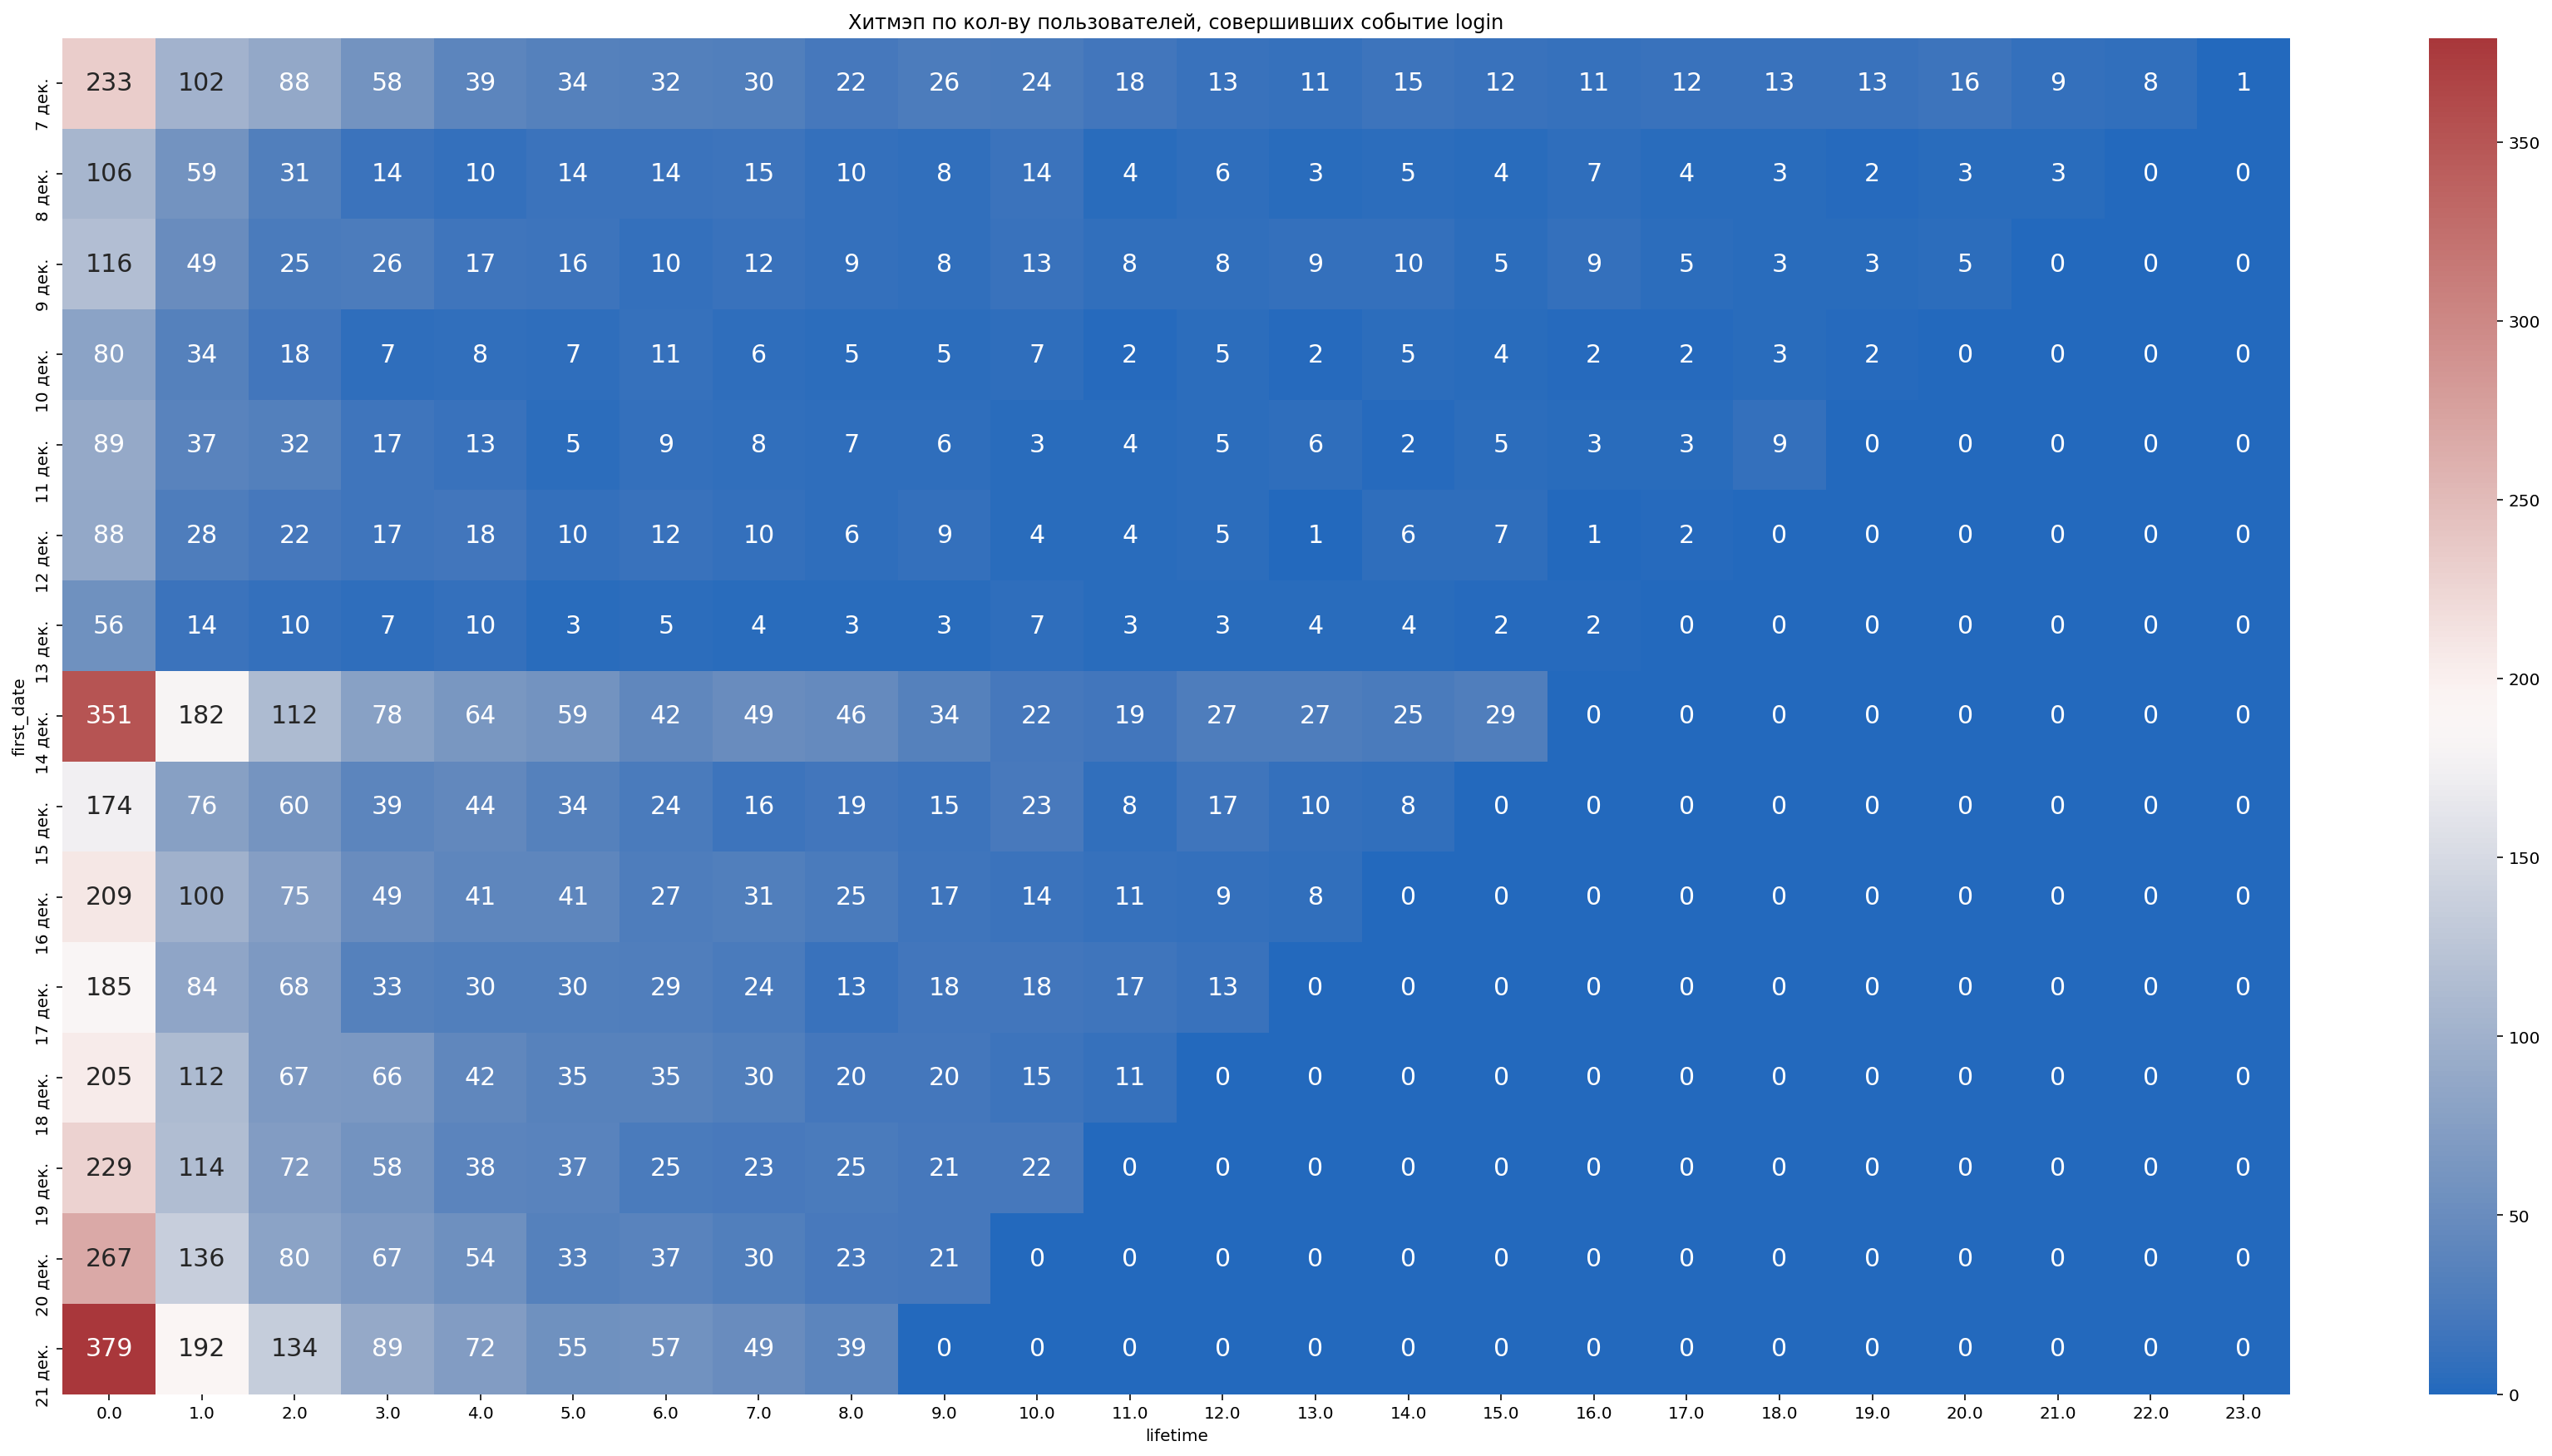

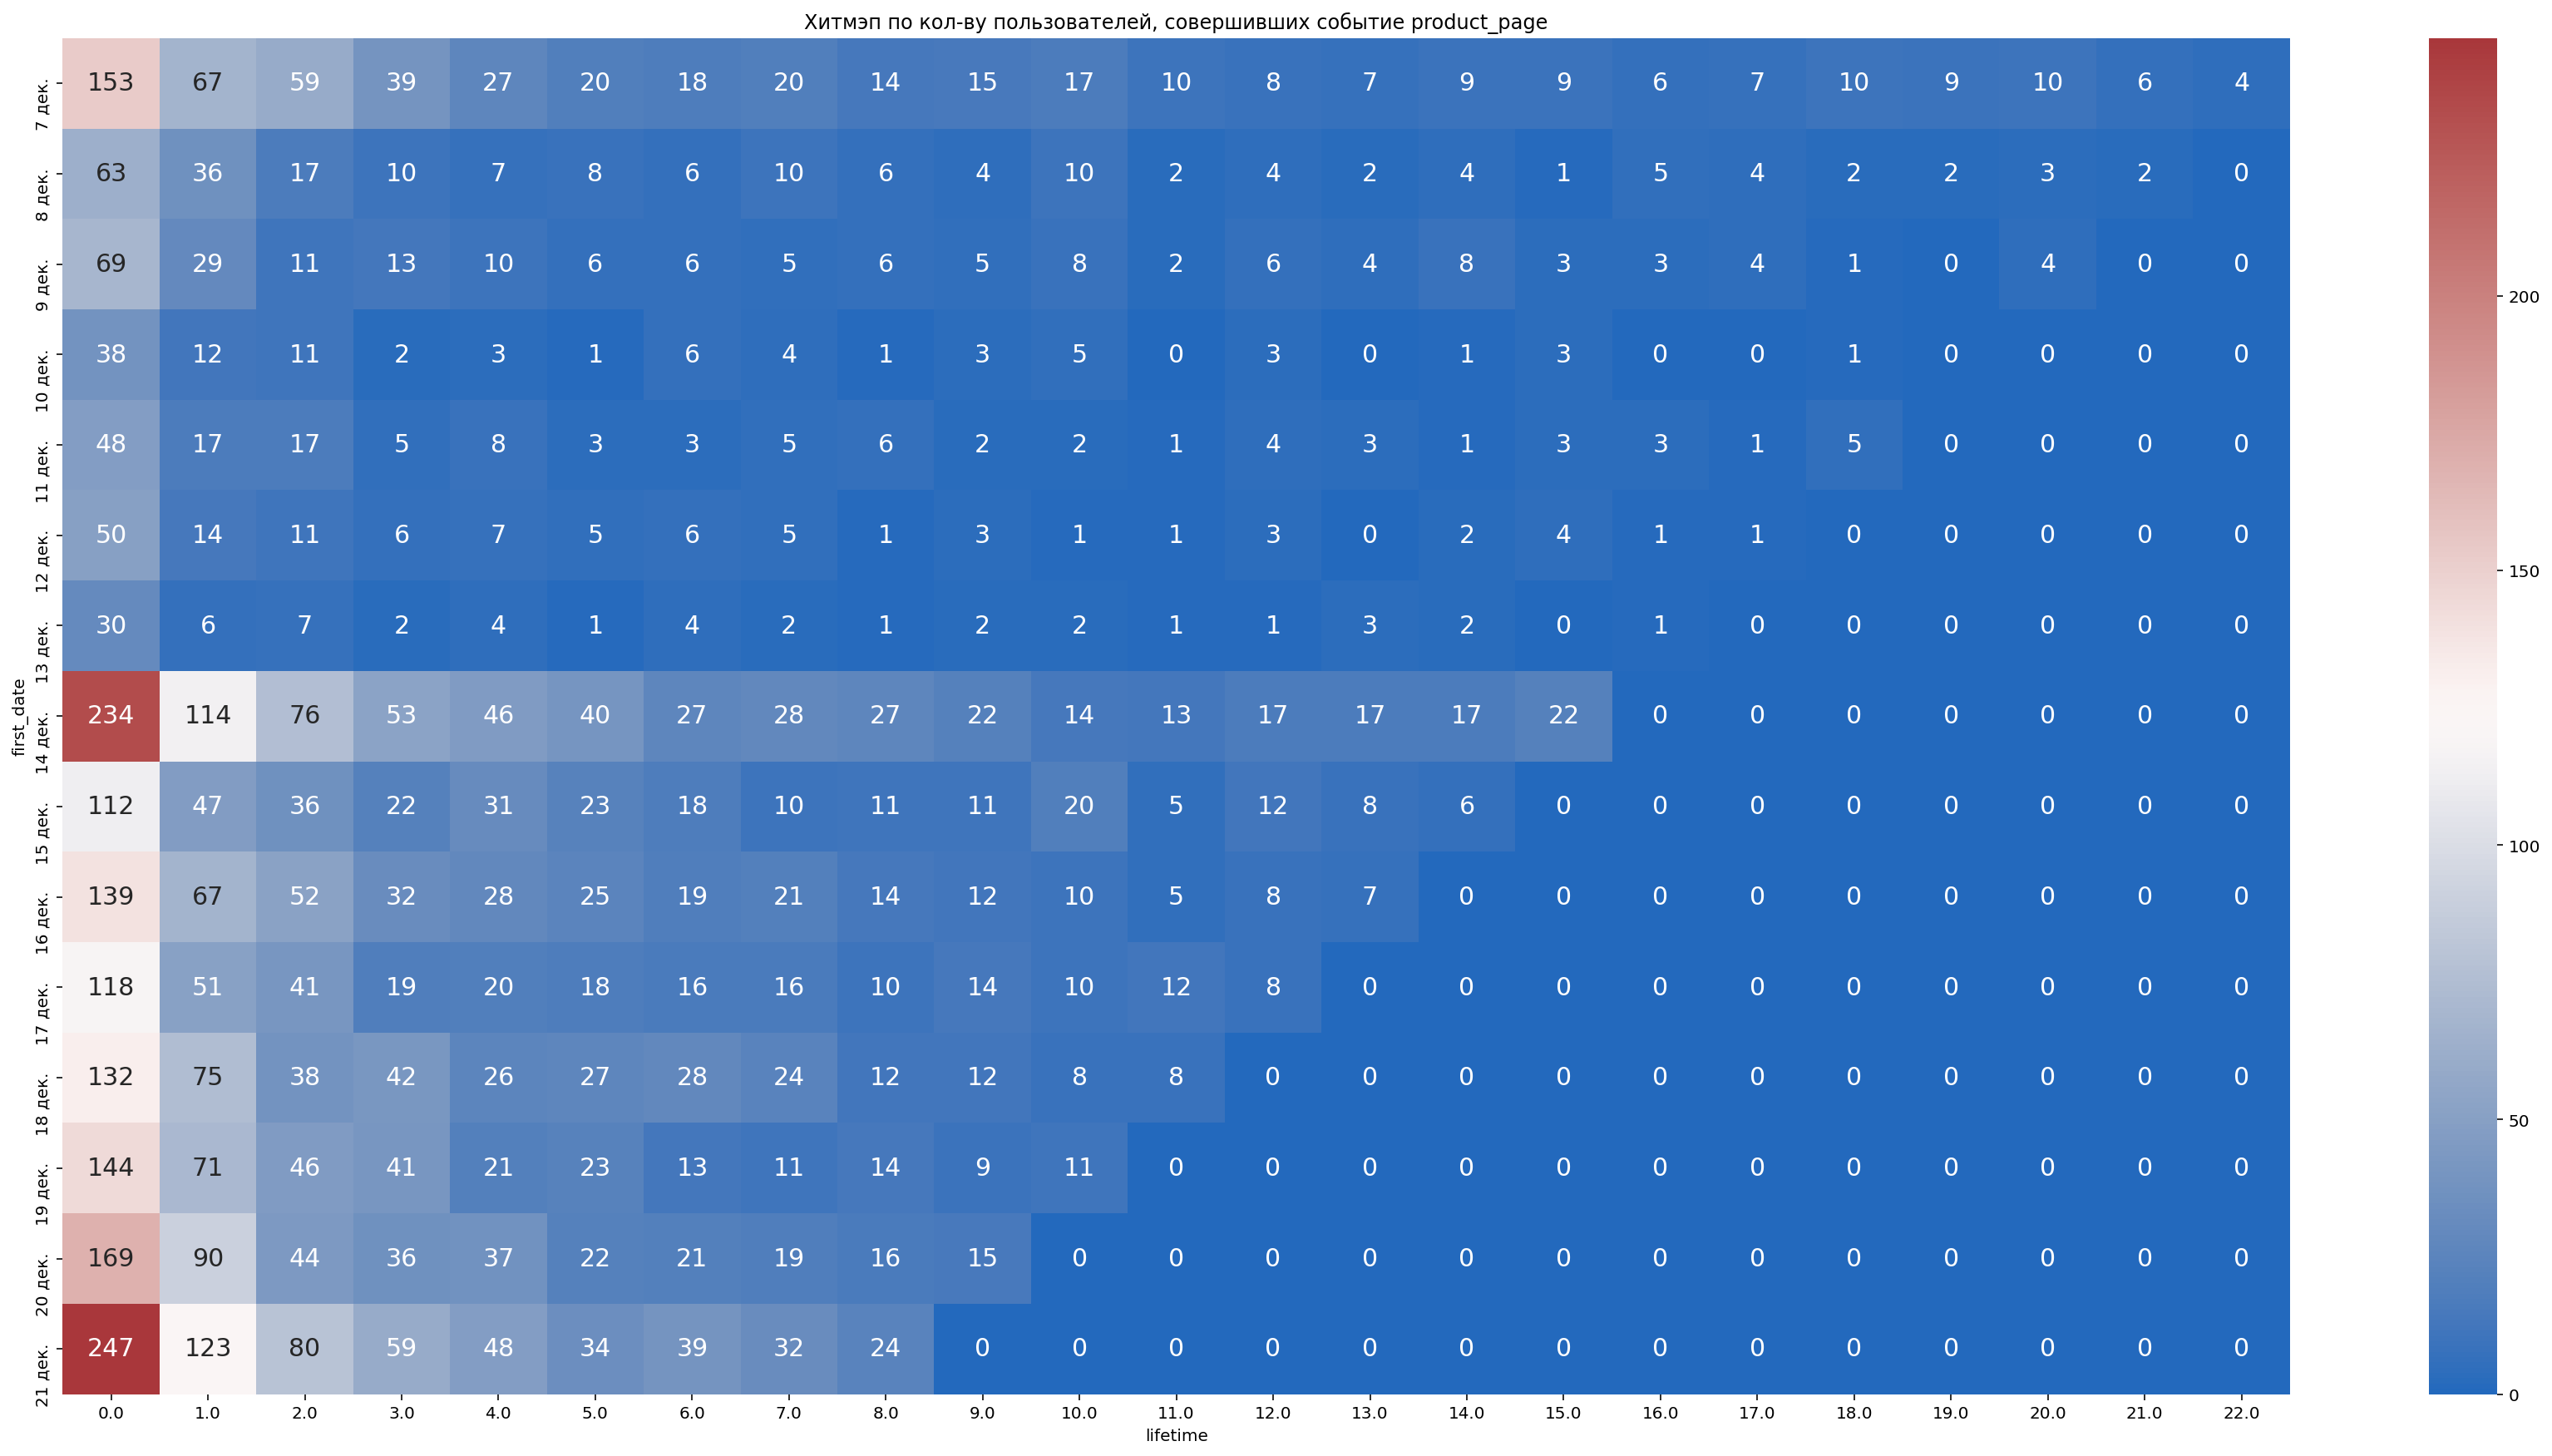

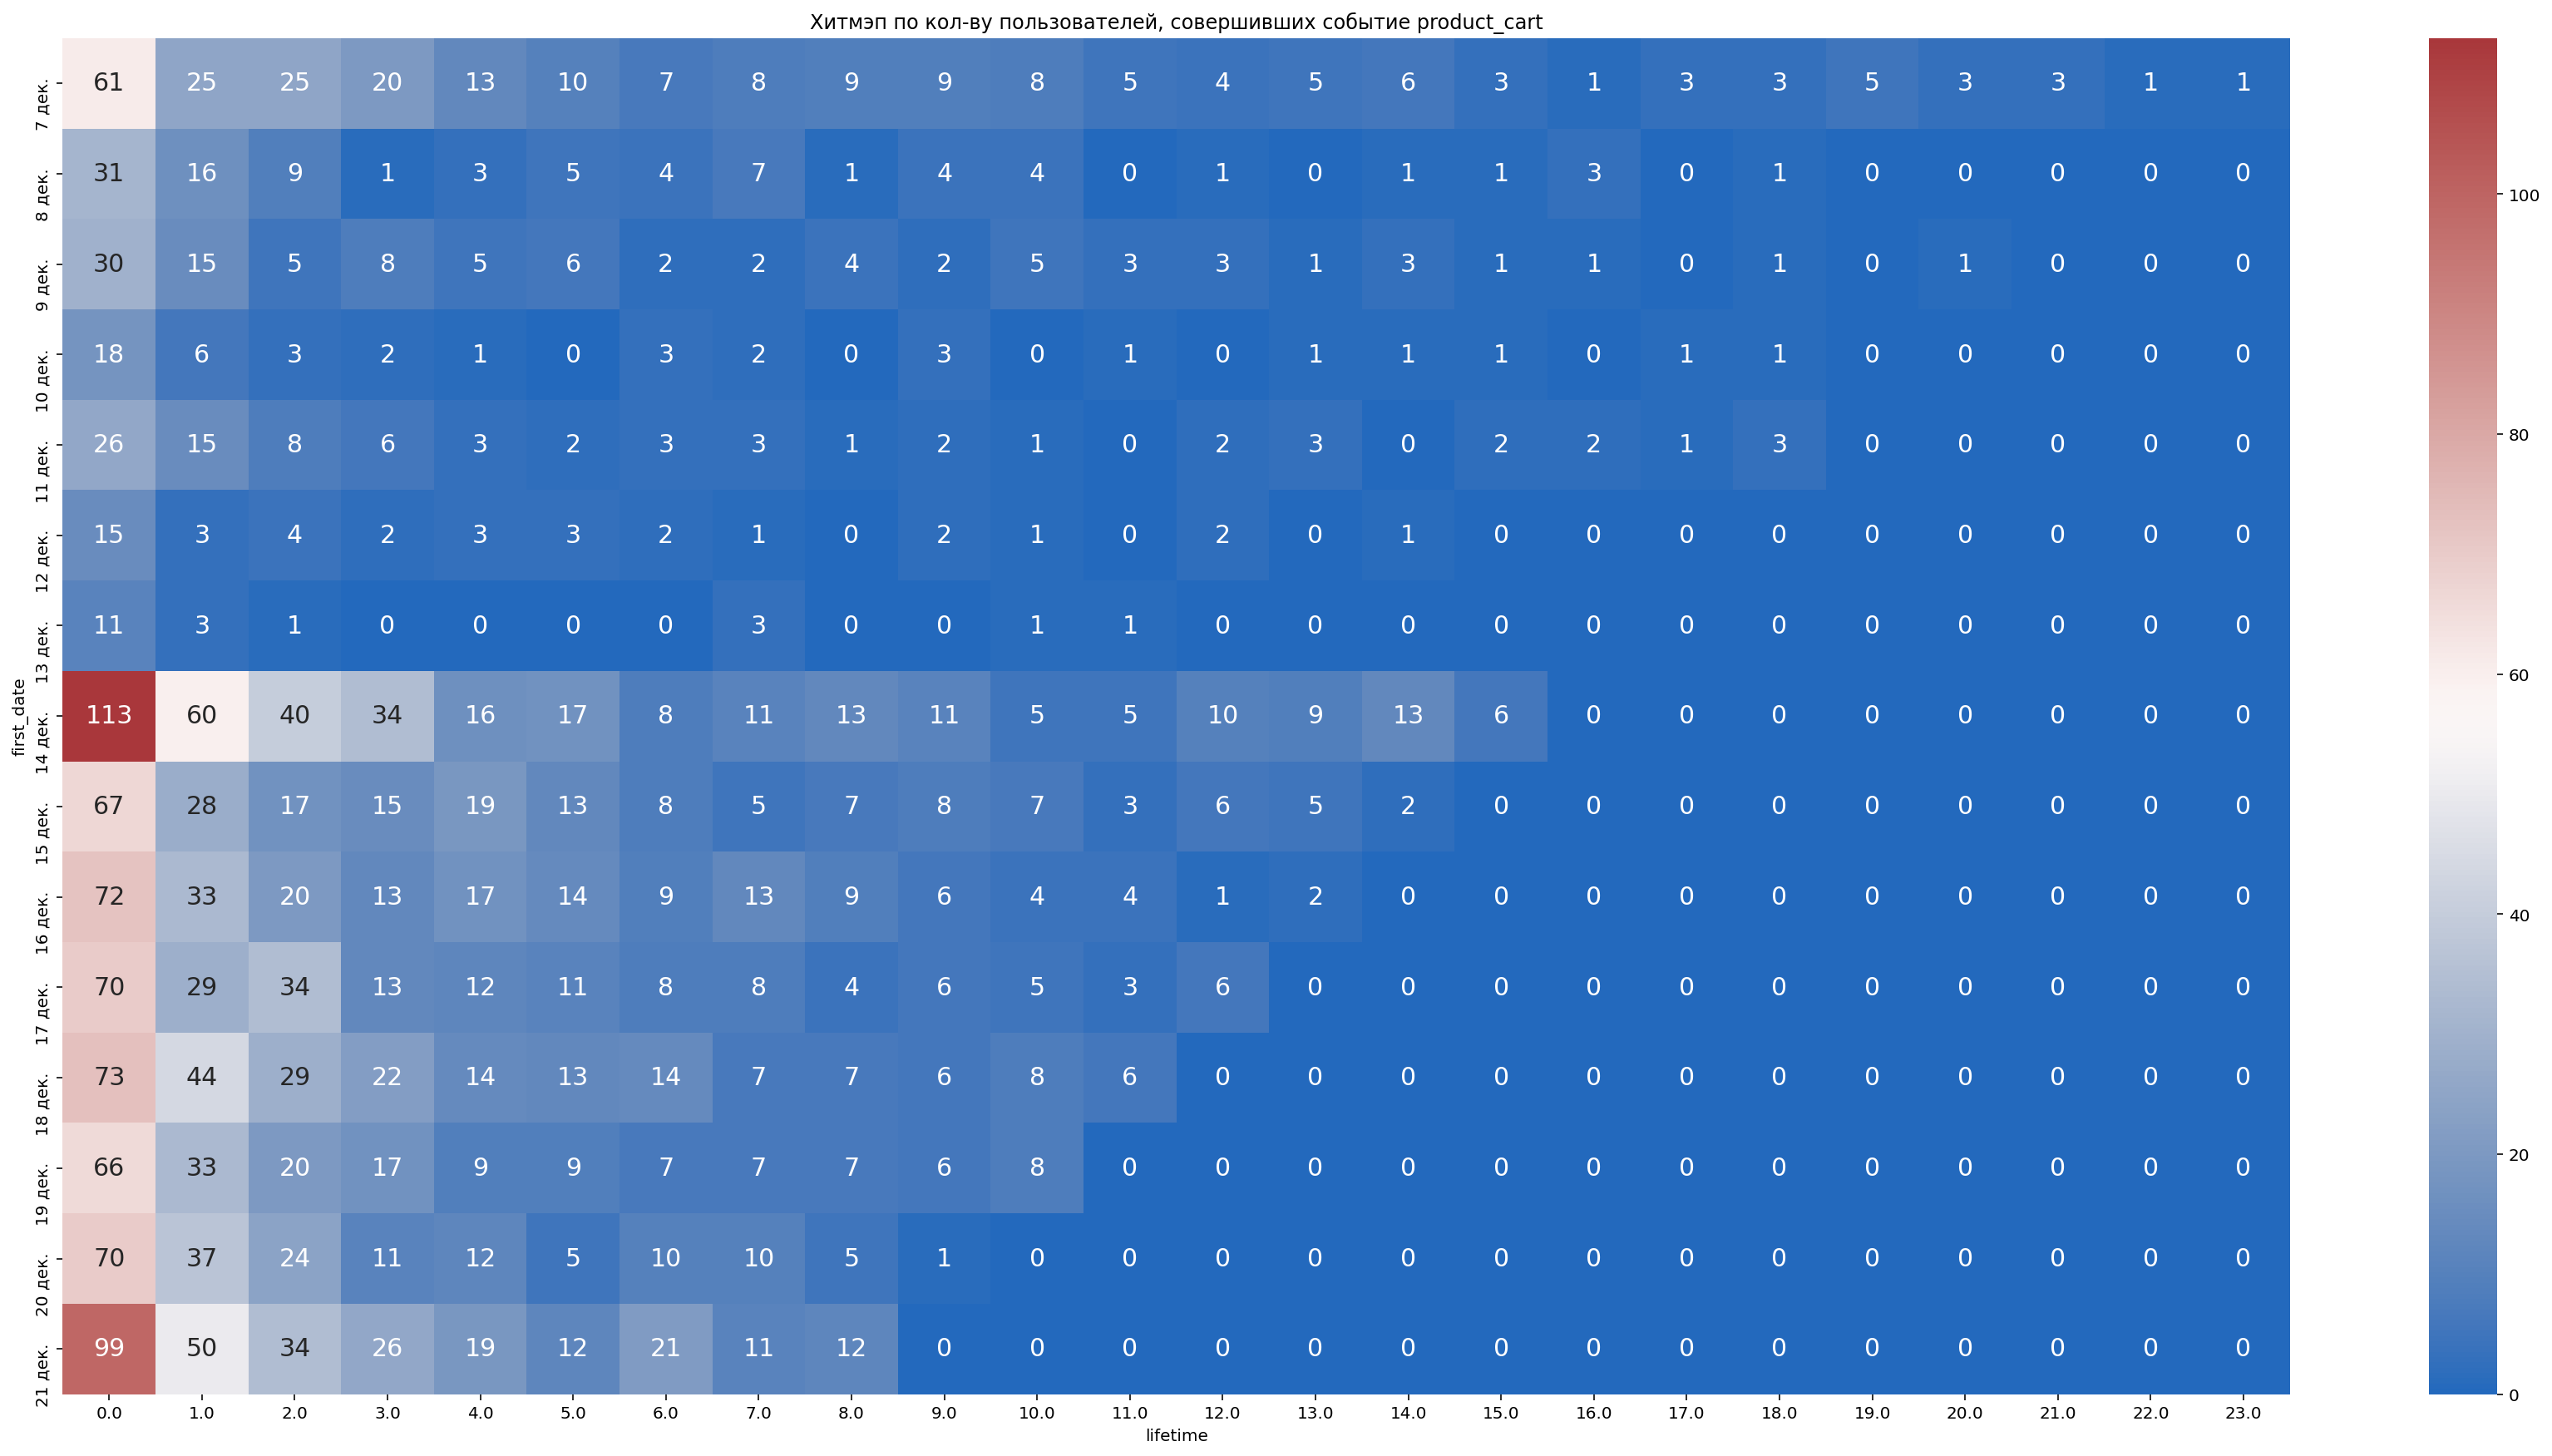

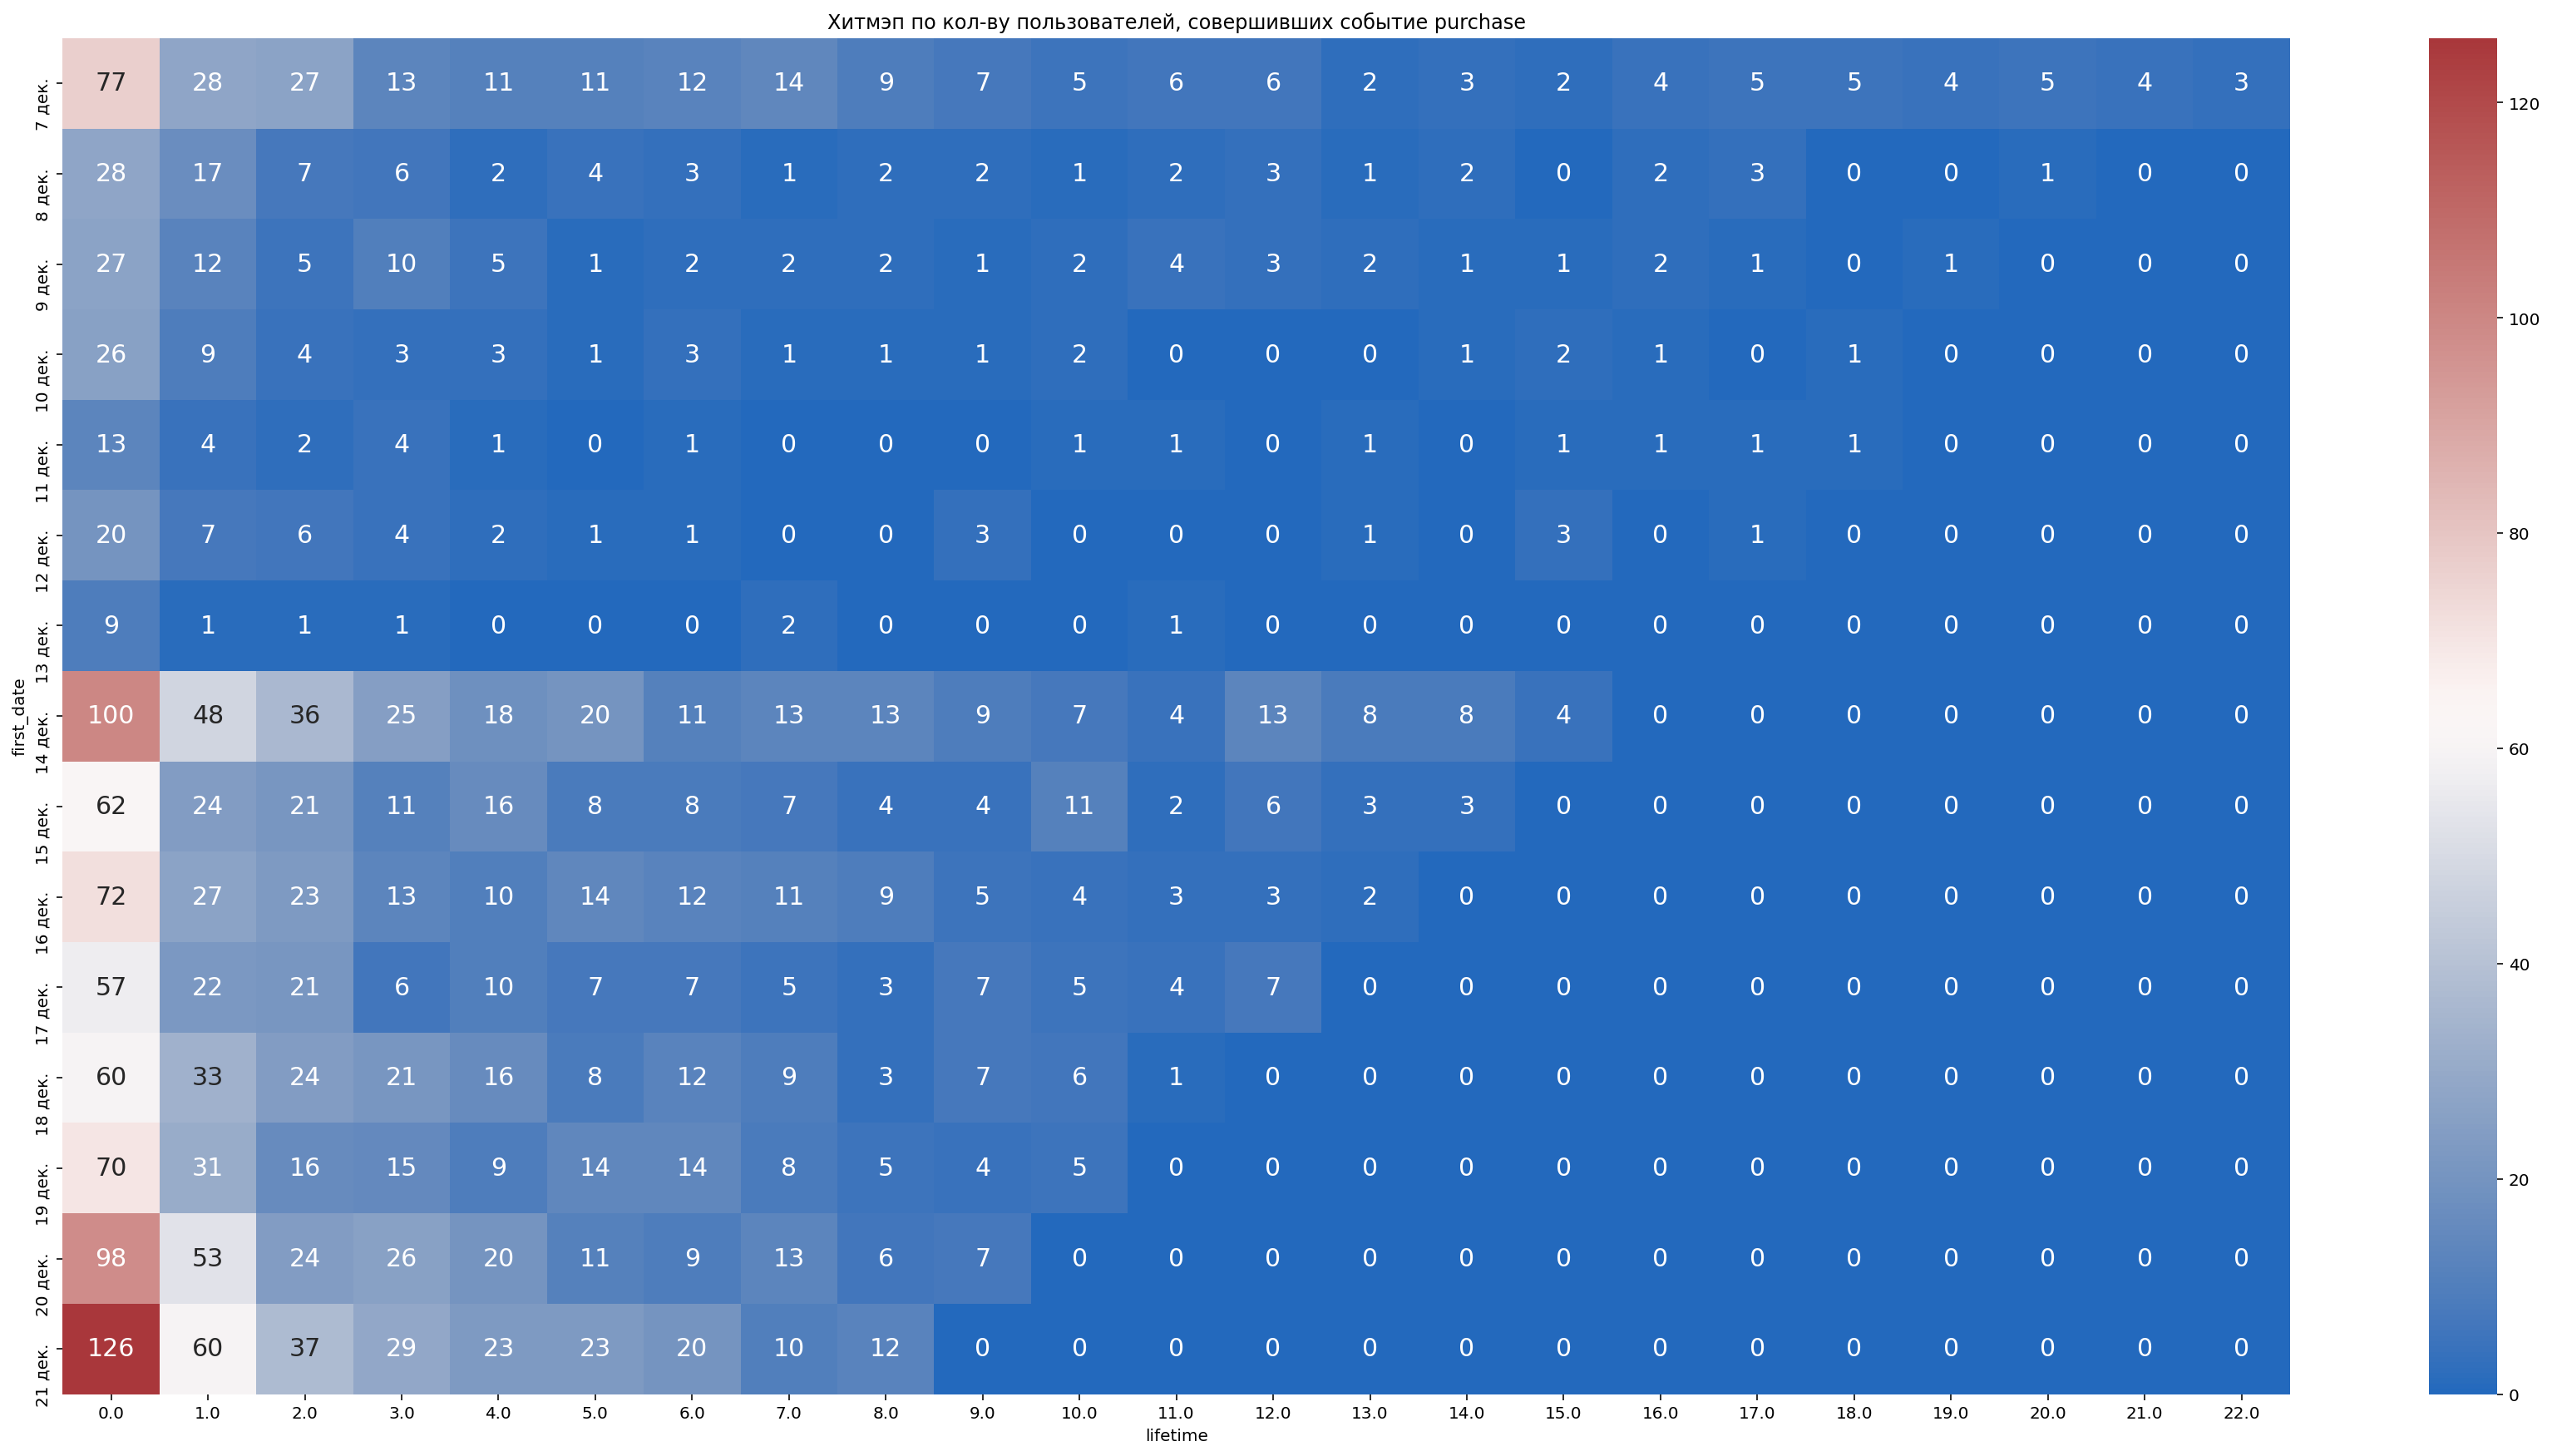

In [27]:
for i in ['login', 'product_page', 'product_cart', 'purchase']:
    plot_lifetimes(i)

Пользователи, зарегистрированные после 16 декабря, не успели набрать 14 дней активности. Однако можно заметить, что основная масса пользователей совершала события в первые несколько дней с момента регистрации. Поэтому включение в выборку юзеров, зарегистрированных после 16 декабря, не окажет существенного влиния. Либо можно сократить горизонт анализа до 9 дней, в этом случае все пользователи успели "дожить".

**Аудитория: 15% новых пользователей из региона EU**

In [28]:
len(users.query('region == "EU"')['user_id'].unique()) / \
len(ab_new_users_filtered.query('region == "EU"')['user_id'].unique()) * 100

11.216343882853094

In [29]:
users.groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,72
CIS,55
EU,4749
N.America,223


С учетом ранее исключенных пересекающихся пользователей, в выборку попало 11% пользователей из Европы от числа всех пользователей, зарегистрированных в период с 7 по 21 декабря. 

Посмотрим, как пользователи распределялись по группам.

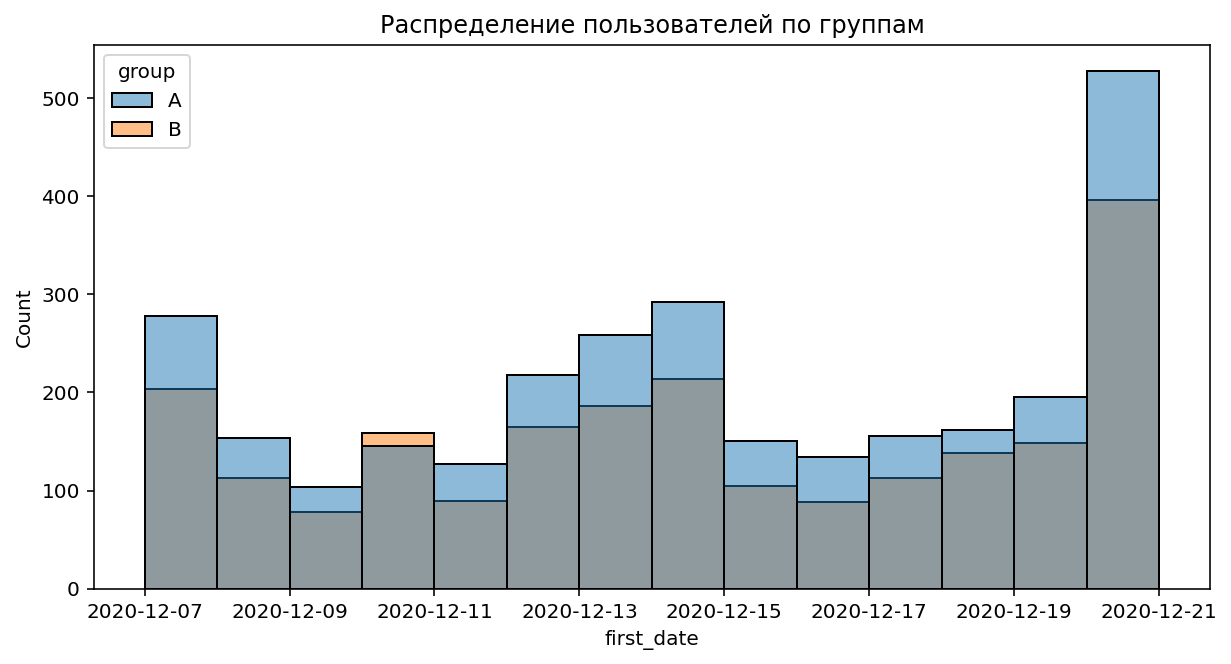

In [30]:
data_to_plot = users.groupby('user_id').agg({'group':'first', 'first_date':'first'})

plt.figure(figsize=(10,5))
sns.histplot(x='first_date', data=data_to_plot, hue='group', bins=14)
plt.title('Распределение пользователей по группам')
plt.show()

В целом при раздаче меток соблюдалась пропорция, за исключением 10 декабря - пользователям было присвоено больше меток В.

Ошибки теста: 
- итоговый размер выборки оказался меньше ожидаемой, что может привести к значительному снижению мощности теста;
- сплит неравномерный (56/43);
- тест завершился раньше, горизон анализа можно сократить до 9 дней;
- доля пользователей из Европы оказалась ниже (11%).

Выявленные ошибки могут привести к увеличению вероятности допустить ошибку второго рода.

## EDA
<a id="3"></a>

Посмотрим на распределение кол-ва событий на пользователя по каждой группе.

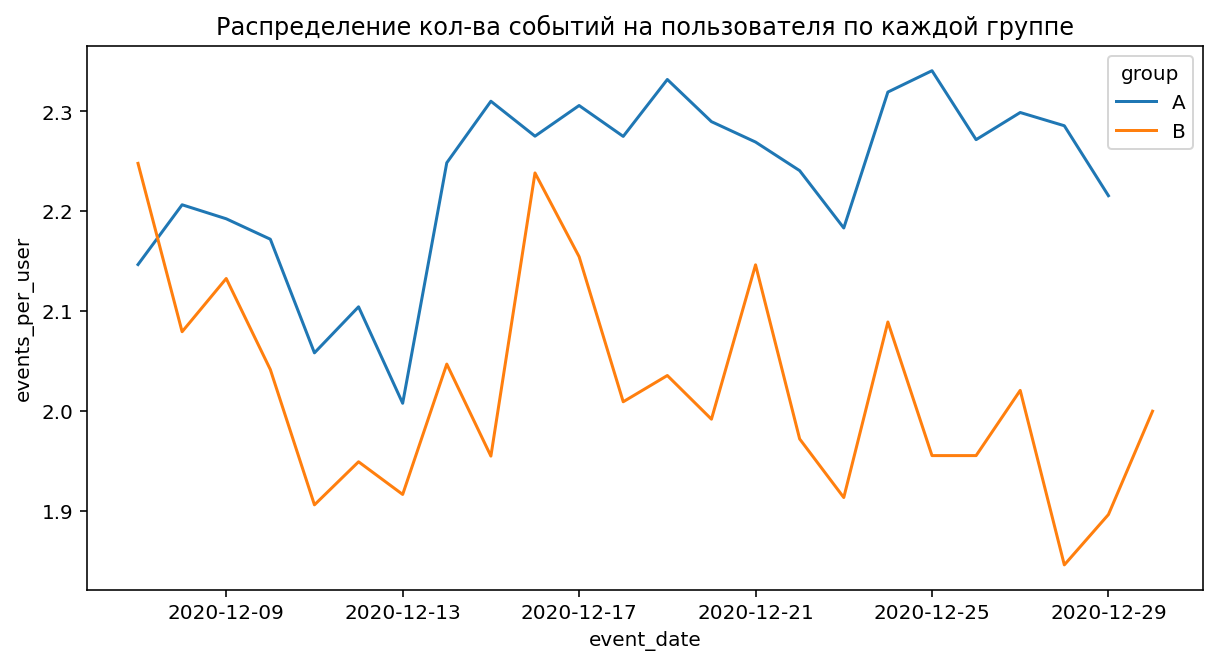

In [31]:
temp = users.groupby(['event_date', 'group']).agg({'event_name':'count', 'user_id':'nunique'}) \
.reset_index() \
.rename(columns={'event_name':'events_number', 'user_id':'users_number'})
temp['events_per_user'] = temp['events_number'] / temp['users_number']

plt.figure(figsize=(10,5))
sns.lineplot(x='event_date', y='events_per_user', data=temp, hue='group')
plt.title('Распределение кол-ва событий на пользователя по каждой группе')
plt.show()

In [32]:
print(temp.query('group == "A"')['events_per_user'].mean())
print(temp.query('group == "B"')['events_per_user'].mean())

2.2326933038369825
2.0209616815928486


В среднем на одного пользователя в контрольной группе приходится больше событий.

In [33]:
events_ratio = users.groupby('group').agg({'event_name':'count', 'user_id':'nunique'})
events_ratio['events_per_user'] = events_ratio['event_name'] / events_ratio['user_id']
events_ratio

,event_name,user_id,events_per_user
group,,,
A,14737,2903,5.076473
B,4067,2196,1.852004


В среднем на одного юзера в контрольной группе приходится 5 событий, в экспериментальной - менее 2. События распределены неравномерно.

In [34]:
x = users[users['event_name'].isna()].shape[0]
print(x)
print(x/users['user_id'].nunique())

2311
0.4532261227691704


Отметим, что 2311 (45%) пользователей в итоговой выборке не совершили ни одного события. Посмотрим, как они распределены между группами.

In [35]:
users[users['event_name'].isna()].groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,821
B,1490


В экспериментальной группе кол-во бездействующих пользователей почти в 2 раза больше. Посмотрим на динамику появления таких пользователей.

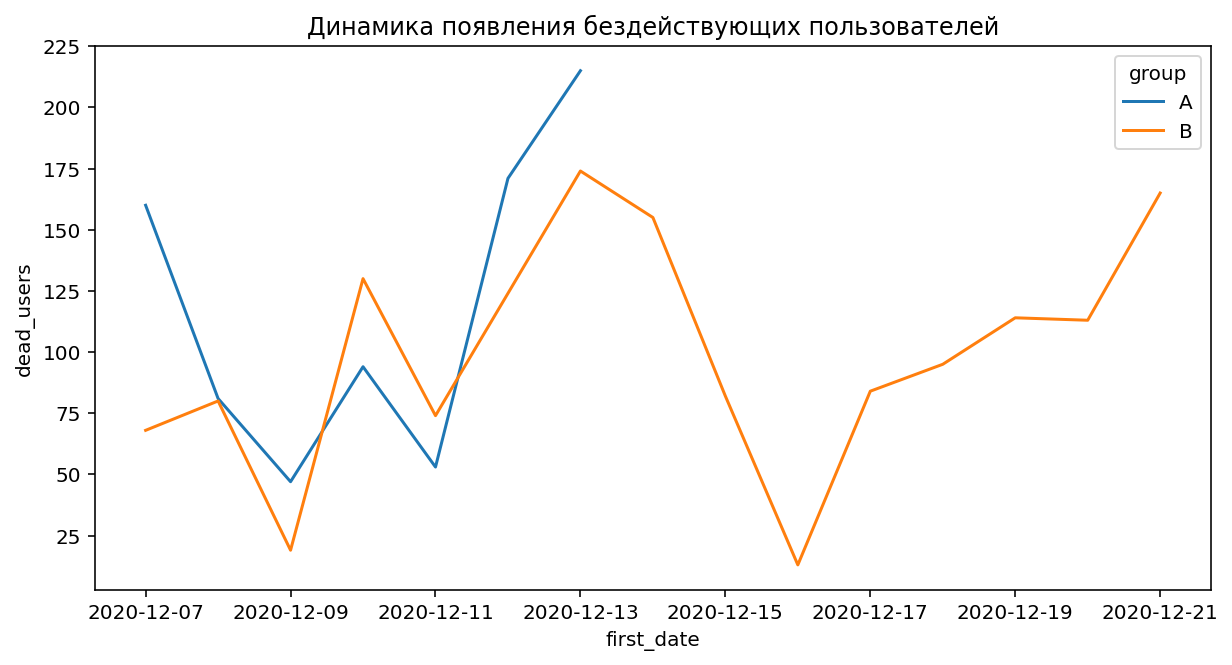

In [36]:
data_to_plot = users[users['event_name'].isna()] \
.groupby(['first_date', 'group']).agg({'user_id':'nunique'}) \
.reset_index() \
.rename(columns={'user_id':'dead_users'})

plt.figure(figsize=(10,5))
sns.lineplot(x='first_date', y='dead_users', data=data_to_plot, hue='group')
plt.title('Динамика появления бездействующих пользователей')
plt.show()

В контрольной группе после 13 декабря не осталось бездействующих пользователей, в то время как в экспериментальной группе такие пользователи наблюдаются в течение всего периода регистраций. Возможные причины бездействия:
- пользователи не смогли зайти в свой логин либо просто зарегистрировались и не входили;
- система распределения по группам работала не корректно;
- внедрение улучшенной рекомендательной системы не привело к появлению более активных юзеров.

Проверим, как число событий в выборках распределено по дням.

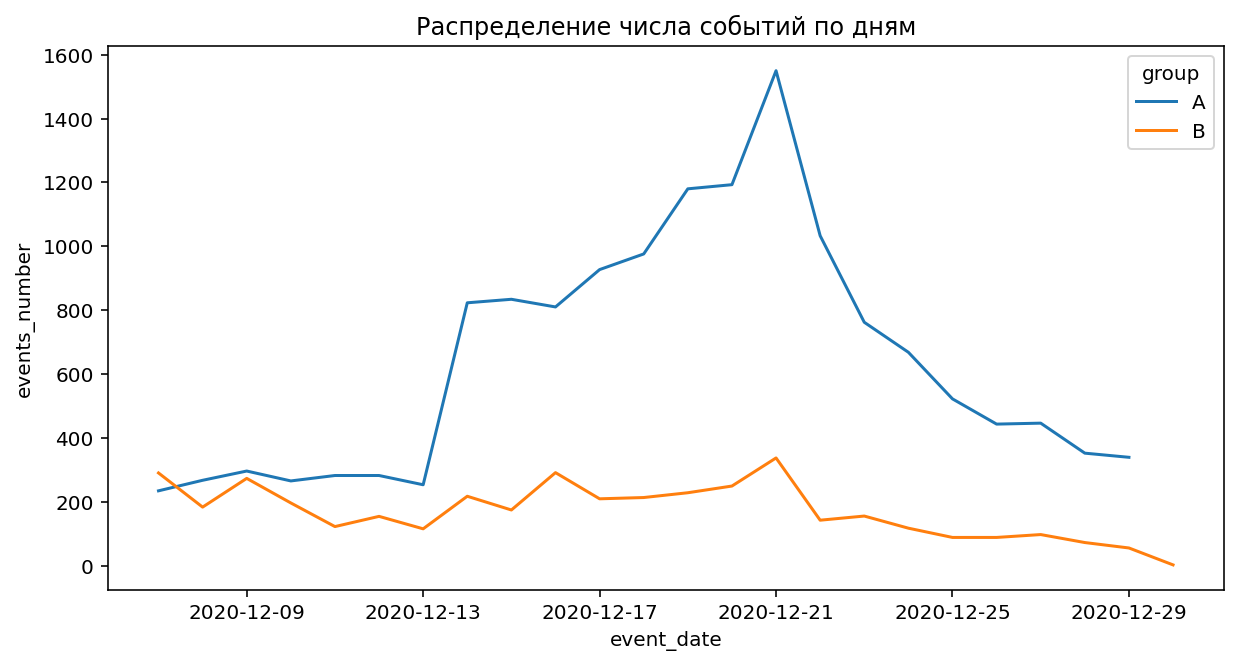

In [37]:
plt.figure(figsize=(10,5))
sns.lineplot(x='event_date', y='events_number', data=temp, hue='group')
plt.title('Распределение числа событий по дням')
plt.show()

Ожидаемо, количество событий по дням значительно выше в контрольной группе в связи с более активными юзерами.

Проанализируем продуктовую воронку и конверсию по результатам теста по обеим группам.

In [38]:
def conversion(group:str):
    '''
    Функция выводит датафрейм с кол-вом уникальных юзеров по каждому событию в группе group,
    конверсию при расчете от числа залогинившихся
    и конверсию при расчете от общего числа юзеров в группе
    '''
    
    data = users.query('group == @group')
    
    # кол-во уникальных пользователей по событиям в группе
    temp_1 = data.groupby('event_name') \
    .agg({'user_id':'nunique'}) \
    .sort_values('user_id', ascending=False)
    
    # CR от логина
    temp_2 = temp_1.apply(lambda x: x/temp_1.iloc[0,0]*100)
    
    # CR от общего числа юзеров
    temp_2['CR от общего числа юзеров'] = temp_1.apply(lambda x: x/data['user_id'].nunique()*100)
    
    # объединяем в один датафрейм
    funnel = pd.merge(temp_1, temp_2, left_index=True, right_index=True) \
    .rename(columns={'user_id_x':f'Кол-во юзеров группы {group}', 'user_id_y':'CR от логина'})
    
    return funnel

In [39]:
display(conversion('A'))
display(conversion('B'))

,Кол-во юзеров группы A,CR от логина,CR от общего числа юзеров
event_name,,,
login,2082,100.000000,71.718911
product_page,1360,65.321806,46.848088
purchase,652,31.316042,22.459525
product_cart,631,30.307397,21.736135


,Кол-во юзеров группы B,CR от логина,CR от общего числа юзеров
event_name,,,
login,706,100.000000,32.149362
product_page,397,56.232295,18.078324
purchase,198,28.045326,9.016393
product_cart,195,27.620397,8.879781


Продуктовая воронка в обеих группах совпадает. Можно заметить, что число пользователей, дошедших до покупки, больше числа тех, кто дошел до корзины. Видимо, реализована возможность быстрой покупки без обязательного перехода в корзину. Экспериментальная группа показала ухудшение конверсии на всех этапах. До события `login` дошлий 72% пользователей группы А и 32% группы B, что соответствует проценту бездействующих пользователей, посчитанных ранее (28% или 821 юзер для А, 68% или 1490 для В). Если брать конверсию от числа юзеров, зашедших в логин, экспериментальная группа также показала более низкие результаты.

## Проверка гипотез
<a id="4"></a>

Определим статистическую значимость различия в конверсиях для каждого события с помощью z-статистики.

Сформулируем гипотезы:
- Н0: конверсии группы А и В равны
- Н1: конверсия группы А больше группы В

In [40]:
def conversion_significance(event:str, cr_from:str):
    '''
    Функция возвращает p_value двух видов конверсий cr_from 
    (от общего числа юзеров total и от залогинившихся login)
    и относительную разницу в конверсиях между группами
    '''
    
    # кол-во пользователей, дошедших до события в каждой группе
    successes = [conversion('A').loc[event, 'Кол-во юзеров группы A'],
                 conversion('B').loc[event, 'Кол-во юзеров группы B']]
    if cr_from == 'total':
        # кол-во пользователей в каждой группе
        trials = [users.query('group == "A"')['user_id'].nunique(), 
                  users.query('group == "B"')['user_id'].nunique()]
    elif cr_from == 'login':
         trials = [conversion('A').iloc[0,0], 
                   conversion('B').iloc[0,0]]
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    z_stat, p_value = proportions_ztest(successes, trials, alternative='larger')
    
    print('p-значение: ', p_value)
    print(f'Относительная разница в конверсии между группам A и B по событию {event} = {p1/p2-1:.2%}')

In [41]:
# стат.значимость по конверсии от обещего числа пользователей
for i in ['login', 'product_page', 'product_cart', 'purchase']:
    conversion_significance(i, 'total')

p-значение:  4.153047826716505e-174
Относительная разница в конверсии между группам A и B по событию login = 123.08%
p-значение:  5.911898698939569e-102
Относительная разница в конверсии между группам A и B по событию product_page = 159.14%
p-значение:  2.828382178671091e-35
Относительная разница в конверсии между группам A и B по событию product_cart = 144.78%
p-значение:  1.4900516973920786e-37
Относительная разница в конверсии между группам A и B по событию purchase = 149.10%


Очевидно, что относительное различие в конверсиях слишком велико, чтобы быть случайным. Тест подтверждает вывод - конверсия от общего числа пользователей группы А действительно выше, чем у группы В. Улучшение метрик не произошло.

In [42]:
# стат.значимость по конверсии от числа залогинившихся
for i in ['product_page', 'product_cart', 'purchase']:
    conversion_significance(i, 'login')

p-значение:  7.685954852343534e-06
Относительная разница в конверсии между группам A и B по событию product_page = 16.16%
p-значение:  0.0883168709565052
Относительная разница в конверсии между группам A и B по событию product_cart = 9.73%
p-значение:  0.051408837838933755
Относительная разница в конверсии между группам A и B по событию purchase = 11.66%


По конверсии от числа залогинивишихся не такая большая разница. По событию `product_page` разница в конверсии оказалась стат.значимой, однако по событиям `product_cart` и `purchase p_value` выше уровня значимости в 5%, поэтому с вероятностью 95% можно утверждать, что наблюдаемые различия являются случайными и конверсии по этим событиям на самом деле равны. Улучшение метрик по результатам эксперимента также не произошло.

In [43]:
users.groupby('first_date').agg({'user_id':'nunique'}).mean() # темп набора юзеров для теста в день

user_id    339.933333
dtype: float64

В целом тест нельзя назвать корректным, т.к. размер выборки оказался недостаточным для того, чтобы заметить 10% относительное изменение в метриках. Например, при конверсии в покупку 22,5% (у группы А) для получения относительного улучшения в 10% необходимо 5723 юзера в тестовой выборке. По факту имеем 2196, мощность теста слишком мала. При среднем наборе в 340 юзеров в день потребовалось бы в 33 дня для полученич необходимого размера выборки (при условии, что все юзеры будут участниками теста), по фатку тест длился меньше месяца.

## Итоговый вывод
<a id="5"></a>

В контрольную группу попали более активные пользователи, в экспериментальной группе большая доля бездействующих юзеров, появляющихся на протяжении всего периода регистрации. Возможные причины бездействия:
- пользователи не смогли зайти в свой логин либо просто зарегистрировались и не входили;
- система распределения по группам работала не корректно;
- внедрение улучшенной рекомендательной системы не привело к появлению более активных юзеров.

Продуктовая воронка в обеих группах совпадает. Экспериментальная группа показала ухудшение конверсии на всех этапах. В целом тест нельзя назвать корректным, т.к. размер выборки оказался недостаточным для того, чтобы заметить 10% относительное изменение в метриках. Также замечены проблемы с раздачей меток (попадались юзеры, участвующие одновременно в двух тестах). При текущем объеме выборки можно утверждать, что изменения, связанные с внедрением улучшенной рекомендательной системы, не привели к улучшению конверсии.